In [42]:
import spreg
from spreg import OLS
from spreg import ML_Lag, ML_Lag_Regimes
import pysal as ps
import libpysal
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import robust_scale
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from tobler.area_weighted import area_join, area_interpolate
import contextily

In [3]:
db = libpysal.io.open('../raw_data/infra_model_gdf.dbf','r')
df = gpd.read_file('../raw_data/infra_model_gdf.shp')

In [4]:
df.columns

Index(['PLR_ID', 'culture', 'outdoor_fa', 'outdoor_le', 'social_hou',
       'public_hou', 'child_pov', 'vegpm20', 'Gymnasium', 'kita', 'stations',
       'extra_edu', 'geometry'],
      dtype='object')

In [5]:
columns = [
        'culture', 'outdoor_fa', 'outdoor_le', 'social_hou',
        'public_hou', 'vegpm20', 'Gymnasium', 'kita', 'stations',
        'extra_edu'
]
#regimes = db.by_col("label")

In [6]:
y = np.array(db.by_col('child_pov')).T
x_names = columns
X = np.array([db.by_col(var) for var in x_names]).T

In [90]:
queen = libpysal.weights.Queen.from_dataframe(df)

In [12]:
inv_dist = libpysal.weights.DistanceBand.from_dataframe(df, 4300, geom_col='geometry', binary=False)

In [92]:
rook = libpysal.weights.Rook.from_dataframe(df)

In [15]:
mllag = ML_Lag(y,
                   X,
                   name_x=columns,
                   name_y='child poverty',
                   w=inv_dist,
                   name_ds='infra_df',
                   name_w='inv_dist', 
              method="full")

In [16]:
print(mllag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :    infra_df
Weights matrix      :    inv_dist
Dependent Variable  :child poverty                Number of Observations:         536
Mean dependent var  :     24.5406                Number of Variables   :          12
S.D. dependent var  :     16.6701                Degrees of Freedom    :         524
Pseudo R-squared    :      0.4734
Spatial Pseudo R-squared:  0.3753
Sigma-square ML     :     146.313                Log likelihood        :   -2104.166
S.E of regression   :      12.096                Akaike info criterion :    4232.331
                                                 Schwarz criterion     :    4283.741

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
----------------------------

In [17]:
mae(df.child_pov, mllag.predy)

9.419781412220585

In [18]:
mse(df.child_pov, mllag.predy)

146.3126057931342

In [21]:
 mllag.u


array([[-1.90853521e+01],
       [-4.90850551e+00],
       [ 5.45296642e+00],
       [ 5.53883598e+00],
       [ 1.87118001e+01],
       [ 2.05909048e+00],
       [ 1.09944738e+01],
       [-6.48179527e+00],
       [-2.72103315e+01],
       [-1.18277342e+01],
       [ 1.40031585e+01],
       [ 1.45932091e+01],
       [-1.70599750e+01],
       [ 1.29090171e+01],
       [-1.96204163e+00],
       [ 3.71937334e+00],
       [-1.57388761e+01],
       [-5.98304237e+00],
       [-1.30643703e+01],
       [ 2.58541094e+00],
       [ 6.98201568e+00],
       [-4.72661322e+00],
       [ 5.44579128e+00],
       [-7.41441785e+00],
       [-8.09341585e+00],
       [-1.38125714e+01],
       [-2.20575620e+01],
       [-5.40735623e+00],
       [ 5.44111584e-01],
       [-5.69822938e+00],
       [ 3.47462745e+00],
       [ 3.44359520e+00],
       [ 6.72208421e+00],
       [-7.19140112e+00],
       [ 3.02565318e+01],
       [ 5.53836948e+00],
       [ 1.14085232e+01],
       [ 3.32392971e+01],
       [ 2.6

In [23]:
# Adding a resituals column to sample dataframe
res = df[['PLR_ID', 'geometry']]
res['residuals'] = mllag.u

# plotting residuals - red = underestimation, blue = overestimation
#df.plot('residuals_mllag', figsize=(15,10), cmap= 'seismic', legend=True)

/Users/Safia/.pyenv/versions/3.8.12/envs/school-map-project/lib/python3.8/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [27]:
import matplotlib as mpl

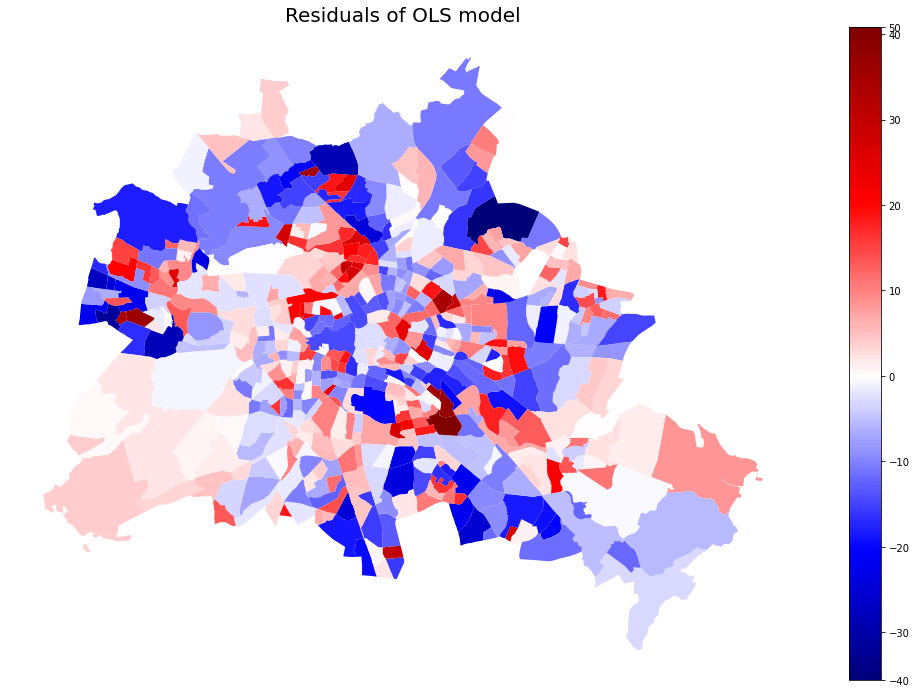

In [28]:
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))
#here goes residuals column
vals = res.residuals
vmin = min(res.residuals)
vmax = max(res.residuals)
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
ax = res.plot(figsize = (18,12), column='residuals', cmap='seismic', norm=norm, legend=True)
ax.axis('off')
ax.set_title('Residuals of OLS model', fontsize=20)
#plt.savefig(fname='plots/ols_residuals.svg',transparent=False, bbox_inches="tight")
plt.show()

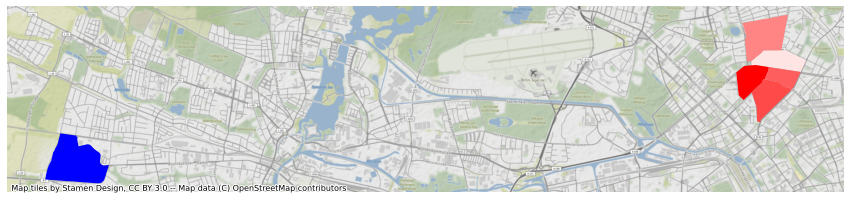

In [44]:
from pysal.explore import esda


# instantiating knn
knn = libpysal.weights.KNN.from_dataframe(df, k=5)
# Row standardise weights
knn.transform = "R"
# Run LISA on residuals
outliers = esda.moran.Moran_Local(mllag.u, knn, permutations=9999)
# Select only LISA cluster cores
error_clusters = outliers.q % 2 == 1
# Filter out non-significant clusters
error_clusters &= outliers.p_sim <= 0.001
# Add `error_clusters` and `local_I` columns
ax = (
    df.assign(
        error_clusters=error_clusters,
        local_I=outliers.Is
        # Retain error clusters only
    )
    .query(
        "error_clusters"
        # Sort by I value to largest plot on top
    )
    .sort_values(
        "local_I"
        # Plot I values
    )
    .plot("local_I", cmap="bwr", marker=".", figsize=(15,10))
)
# Add basemap
contextily.add_basemap(ax, crs=df.crs)
# Remove axes
ax.set_axis_off();

In [31]:
west = gpd.read_file('../raw_data/more_maps/Ortsteile__Berlin_West_EPSG54030.shp')
east = gpd.read_file('../raw_data/more_maps/Ortsteile__Berlin_Ost_EPSG54030.shp')

east.to_crs(crs='EPSG:25833', inplace=True)

west.to_crs(crs='EPSG:25833', inplace=True)

west = west.dissolve()

east = east.dissolve()

eastwest = east.append(west)

eastwest['east'] = eastwest.OBJECTID.map({1:1,
                                             2:0})

df_east = df.sjoin_nearest(
    eastwest, how='left').dissolve(
    by='PLR_ID')

df = df.merge(df_east.reset_index()[['PLR_ID','east']], on='PLR_ID')

/var/folders/sx/4s_zvfwj1xddph7py3s74ych0000gn/T/ipykernel_8565/4049039317.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eastwest = east.append(west)


In [33]:
mllag_regimes = ML_Lag_Regimes(y,
                   X,
                    regimes=df['east'],
                   name_x=columns,
                   name_y='child poverty',
                   w=inv_dist,
                   name_ds='selected_ds',
                   name_w='inv_dist')

/Users/Safia/.pyenv/versions/3.8.12/envs/school-map-project/lib/python3.8/site-packages/scipy/optimize/_minimize.py:870: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


In [34]:
print(mllag_regimes.summary) # only significant difference in the coefficients is in green volume

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG - REGIMES (METHOD = full)
---------------------------------------------------------------------------
Data set            : selected_ds
Weights matrix      :    inv_dist
Dependent Variable  :child poverty                Number of Observations:         536
Mean dependent var  :     24.5406                Number of Variables   :          23
S.D. dependent var  :     16.6701                Degrees of Freedom    :         513
Pseudo R-squared    :      0.4862
Spatial Pseudo R-squared:  0.3815
Sigma-square ML     :     142.769                Log likelihood        :   -2098.075
S.E of regression   :      11.949                Akaike info criterion :    4242.149
                                                 Schwarz criterion     :    4340.684

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------

In [35]:
mae(df.child_pov, mllag_regimes.predy)

9.224549247513433

In [36]:
mse(df.child_pov, mllag_regimes.predy)

142.7693535460977

In [37]:
# Adding a resituals column to sample dataframe
df['residuals'] = mllag_regimes.u

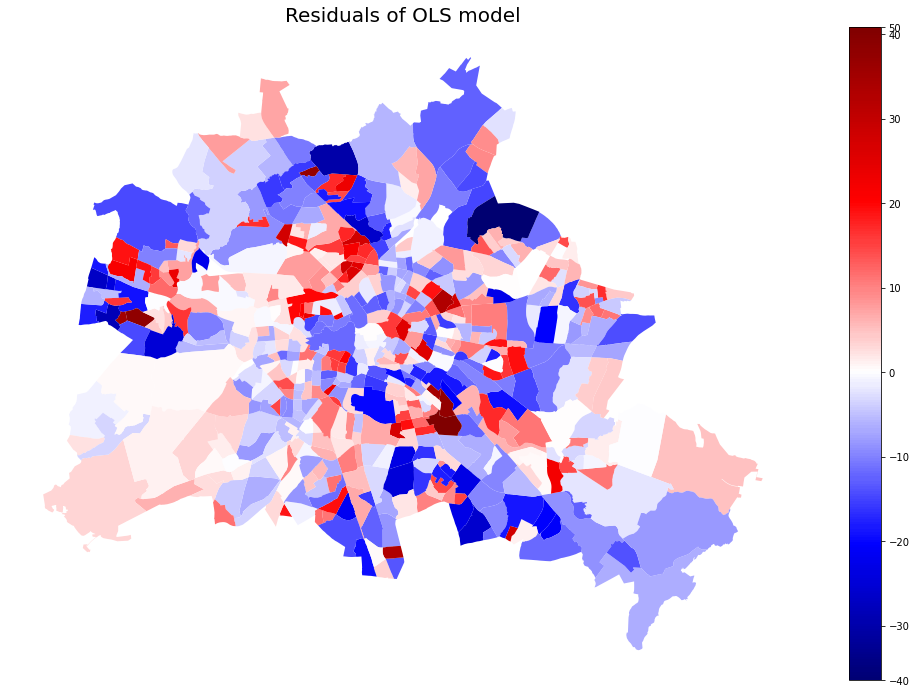

In [38]:
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))
#here goes residuals column
vals = df.residuals
vmin = min(df.residuals)
vmax = max(df.residuals)
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
ax = df.plot(figsize = (18,12), column='residuals', cmap='seismic', norm=norm, legend=True)
ax.axis('off')
ax.set_title('Residuals of OLS model', fontsize=20)
#plt.savefig(fname='plots/ols_residuals.svg',transparent=False, bbox_inches="tight")
plt.show()

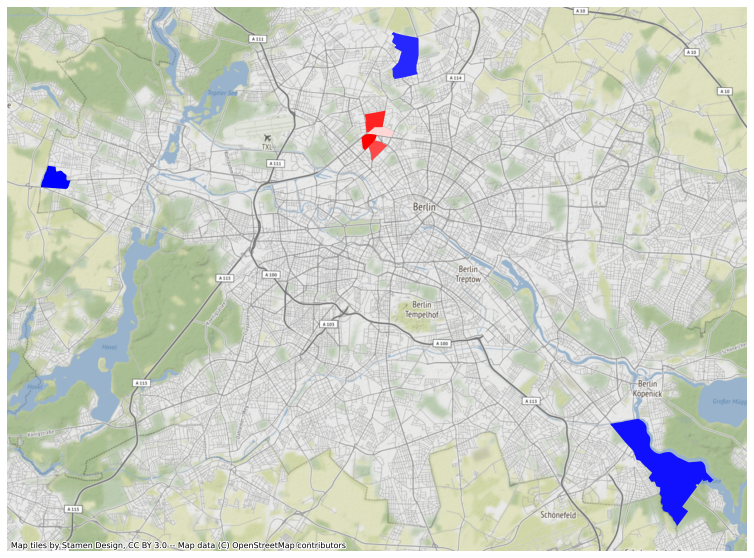

In [45]:

# instantiating knn
knn = libpysal.weights.KNN.from_dataframe(df, k=5)
# Row standardise weights
knn.transform = "R"
# Run LISA on residuals
outliers = esda.moran.Moran_Local(mllag_regimes.u, knn, permutations=9999)
# Select only LISA cluster cores
error_clusters = outliers.q % 2 == 1
# Filter out non-significant clusters
error_clusters &= outliers.p_sim <= 0.001
# Add `error_clusters` and `local_I` columns
ax = (
    df.assign(
        error_clusters=error_clusters,
        local_I=outliers.Is
        # Retain error clusters only
    )
    .query(
        "error_clusters"
        # Sort by I value to largest plot on top
    )
    .sort_values(
        "local_I"
        # Plot I values
    )
    .plot("local_I", cmap="bwr", marker=".", figsize=(15,10))
)
# Add basemap
contextily.add_basemap(ax, crs=df.crs)
# Remove axes
ax.set_axis_off();